In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

test_data = pd.read_csv('../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv')
num_test_samples = test_data.shape[0]

x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)
y_test_int = test_data.iloc[:, 0].to_numpy()

x_test_corrected = np.array([np.fliplr(np.rot90(img.reshape(28, 28), k=3))
                            for img in x_test]).reshape(num_test_samples, 28, 28, 1)

2024-05-24 20:35:06.203296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 20:35:06.203332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 20:35:06.204091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 20:35:06.262222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 20:35:07.083317: W tensorflow/compiler/

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[2],
            [tf.config.LogicalDeviceConfiguration(memory_limit=24576)])
    except RuntimeError as e:
        print(e)

2024-05-24 20:35:13.205180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 20:35:13.476856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 20:35:13.477162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

IndexError: list index out of range

In [ ]:
x_test_resized = tf.image.resize(x_test_corrected, [32, 32])
x_test_resized = tf.cast(x_test_resized, tf.float32)
x_test_resized_np = x_test_resized.numpy()

2024-05-19 16:43:03.594074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 16:43:03.619766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 16:43:03.620097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
def get_latest_model_file(checkpoint_dir):
    files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.hdf5')]
    files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    return os.path.join(checkpoint_dir, files[0]) if files else None

In [3]:
def label_to_char(label):
    if 0 <= label <= 9:
        return str(label)
    elif 10 <= label <= 35:
        return chr(label + 87)
    elif 36 <= label <= 61:
        return chr(label + 29)
    else:
        raise ValueError(f"Unexpected label: {label}")

# LeNet-5

In [5]:
checkpoint_dir = './checkpoints/checkpoints_lenet/'
latest_model_file = get_latest_model_file(checkpoint_dir)

if latest_model_file:
    print(f"Loading model from: {latest_model_file}")
    model = tf.keras.models.load_model(latest_model_file)
    loss_lenet, acc_lenet = model.evaluate(x_test_corrected, y_test_int)
    print("Loss:", loss_lenet)
    print("Accuracy:", acc_lenet)
else:
    print("No model files found in the checkpoint directory.")

Loading model from: ./checkpoints/checkpoints_lenet/weights.1716098733.hdf5


2024-05-19 16:43:08.688687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800


3636/3636 [==============================] - 8s 2ms/step - loss: 11.2152 - accuracy: 0.1030
Loss: 11.215188980102539
Accuracy: 0.10299856960773468


7/7 [==============================] - 0s 7ms/step


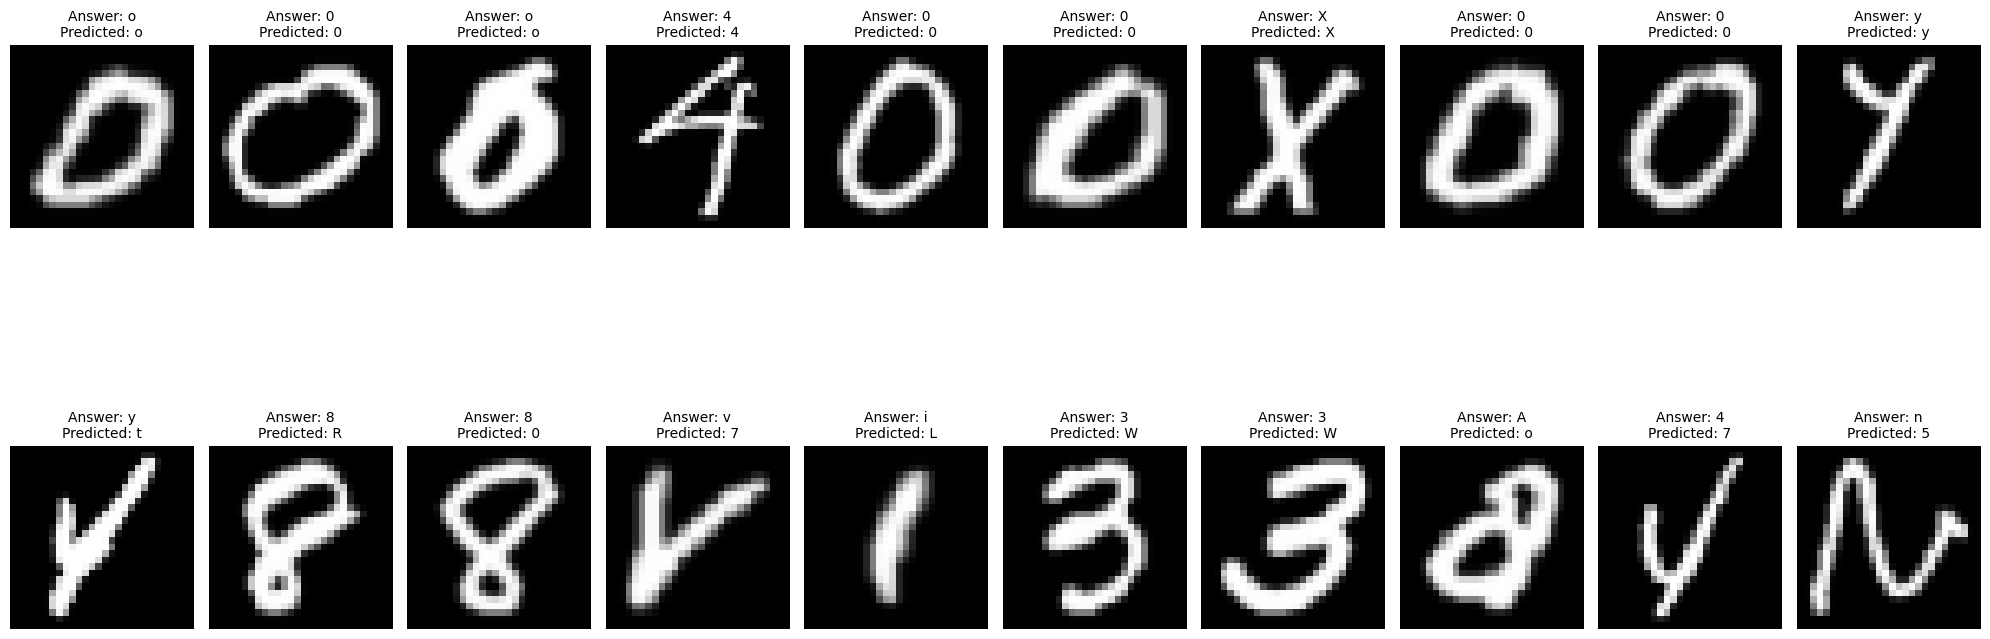

In [6]:
num_samples = 200
sample_indices = np.random.choice(num_test_samples, num_samples, replace=False)
sample_images = x_test_corrected[sample_indices]
sample_labels = y_test_int[sample_indices]

predicted_labels = model.predict(sample_images)
predicted_labels_int = np.argmax(predicted_labels, axis=1)

correct_indices = np.where(predicted_labels_int == sample_labels)[0]
incorrect_indices = np.where(predicted_labels_int != sample_labels)[0]

correct_images = sample_images[correct_indices]
correct_labels = sample_labels[correct_indices]
correct_predictions = predicted_labels_int[correct_indices]

incorrect_images = sample_images[incorrect_indices]
incorrect_labels = sample_labels[incorrect_indices]
incorrect_predictions = predicted_labels_int[incorrect_indices]

num_display = 10
plt.figure(figsize=(20, 10))

for i in range(min(num_display, len(correct_images))):
    plt.subplot(2, num_display, i + 1)
    plt.imshow(correct_images[i].reshape(28, 28), cmap='gray')
    true_label = label_to_char(correct_labels[i])
    predicted_label = label_to_char(correct_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

for i in range(min(num_display, len(incorrect_images))):
    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(incorrect_images[i].reshape(28, 28), cmap='gray')
    true_label = label_to_char(incorrect_labels[i])
    predicted_label = label_to_char(incorrect_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# ResNet50

In [7]:
checkpoint_dir = './checkpoints/checkpoints_resnet/'

latest_model_file = get_latest_model_file(checkpoint_dir)
if latest_model_file:
    print(f"Loading model from: {latest_model_file}")
    model = tf.keras.models.load_model(latest_model_file)
    loss_resnet, acc_resnet = model.evaluate(x_test_resized_np, y_test_int)
    print("Loss:", loss_resnet)
    print("Accuracy:", acc_resnet)
else:
    print("No model files found in the checkpoint directory.")

Loading model from: ./checkpoints/checkpoints_resnet/weights.1716098733.hdf5
3636/3636 [==============================] - 30s 8ms/step - loss: 11.0214 - accuracy: 0.1113
Loss: 11.021444320678711
Accuracy: 0.11131170392036438


7/7 [==============================] - 1s 41ms/step


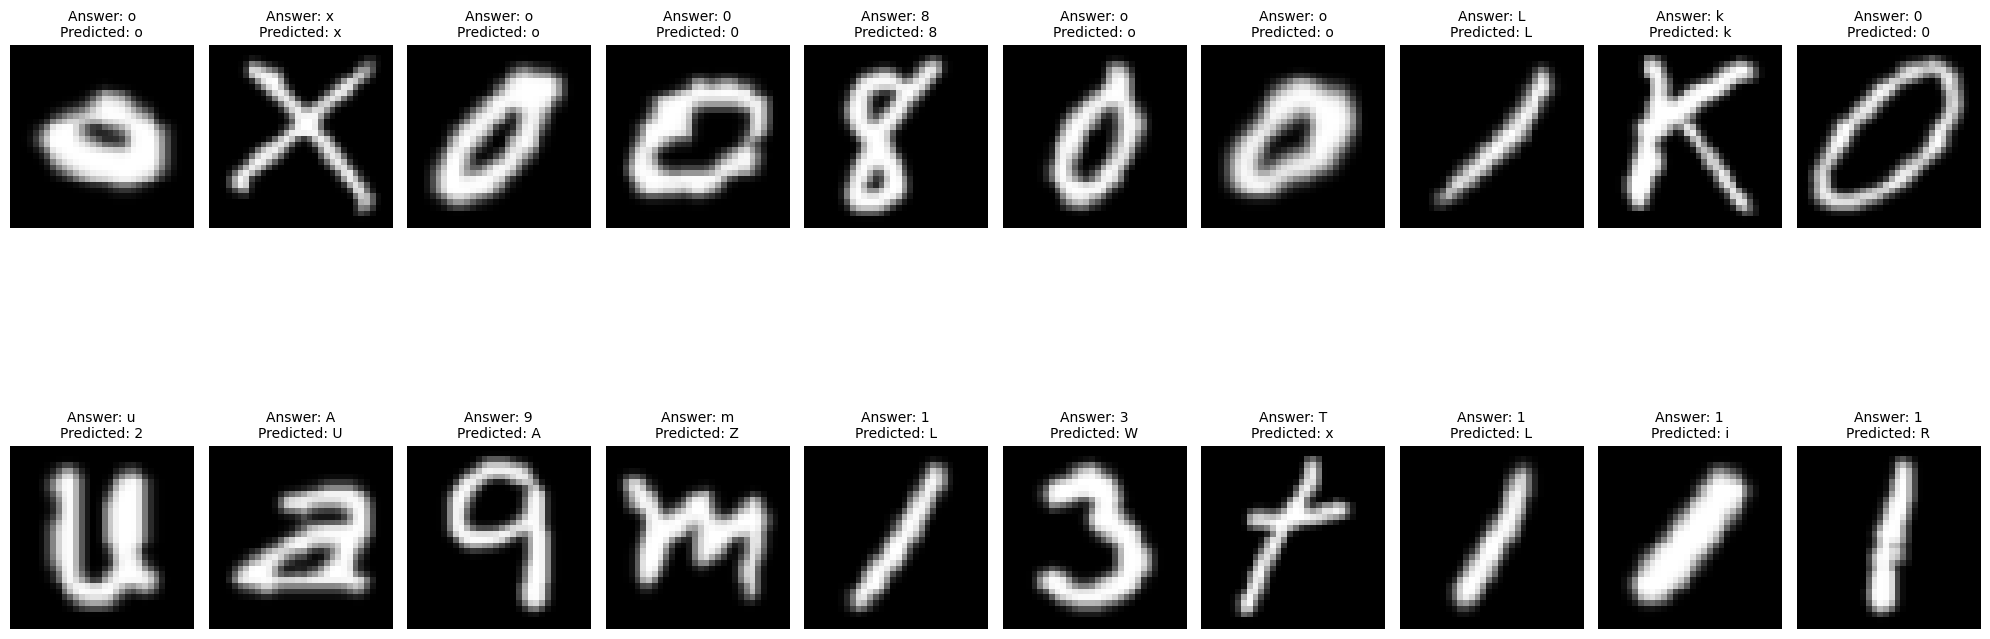

In [8]:
num_samples = 200
sample_indices = np.random.choice(num_test_samples, num_samples, replace=False)
sample_images = x_test_resized_np[sample_indices]
sample_labels = y_test_int[sample_indices]

predicted_labels = model.predict(sample_images)
predicted_labels_int = np.argmax(predicted_labels, axis=1)

correct_indices = np.where(predicted_labels_int == sample_labels)[0]
incorrect_indices = np.where(predicted_labels_int != sample_labels)[0]

correct_images = sample_images[correct_indices]
correct_labels = sample_labels[correct_indices]
correct_predictions = predicted_labels_int[correct_indices]

incorrect_images = sample_images[incorrect_indices]
incorrect_labels = sample_labels[incorrect_indices]
incorrect_predictions = predicted_labels_int[incorrect_indices]

num_display = 10
plt.figure(figsize=(20, 10))

for i in range(min(num_display, len(correct_images))):
    plt.subplot(2, num_display, i + 1)
    plt.imshow(correct_images[i].reshape(32, 32), cmap='gray')
    true_label = label_to_char(correct_labels[i])
    predicted_label = label_to_char(correct_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

for i in range(min(num_display, len(incorrect_images))):
    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(incorrect_images[i].reshape(32, 32), cmap='gray')
    true_label = label_to_char(incorrect_labels[i])
    predicted_label = label_to_char(incorrect_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Our Model

In [16]:
checkpoint_dir = './checkpoints/checkpoints_ours/'

latest_model_file = get_latest_model_file(checkpoint_dir)
if latest_model_file:
    print(f"Loading model from: {latest_model_file}")
    model = tf.keras.models.load_model(latest_model_file)
    loss_ours, acc_ours = model.evaluate(x_test, y_test_int)
    print("Loss:", loss_ours)
    print("Accuracy:", acc_ours)
    predictions = model.predict(x_test_corrected)
else:
    print("No model files found in the checkpoint directory.")
    predictions = None

Loading model from: ./checkpoints/checkpoints_ours/weights.1716376780.hdf5
3636/3636 [==============================] - 14s 4ms/step - loss: 0.3124 - accuracy: 0.8831
Loss: 0.3123863637447357
Accuracy: 0.8831261396408081
3636/3636 [==============================] - 10s 3ms/step


In [17]:
from sklearn.manifold import TSNE

tsne_result_path = './tsne_results_ours.csv'

if predictions is not None:
    if os.path.exists(tsne_result_path):
        images_tsne = pd.read_csv(tsne_result_path).to_numpy()
    else:
        # t-SNE 적용
        tsne = TSNE(n_components=2, random_state=42)
        images_tsne = tsne.fit_transform(predictions)
        # t-SNE 결과 저장
        np.savetxt(tsne_result_path, images_tsne, delimiter=',')
else:
    print("No predictions to apply t-SNE.")

In [18]:
def label_transform(label):
    if 0 <= label <= 9:
        return str(label)
    elif 10 <= label <= 35:
        return chr(label + ord('a') - 10)
    elif 36 <= label <= 61:
        return chr(label + ord('A') - 36)
    else:
        return str(label)


sample_images = x_test.reshape((num_test_samples, -1))
sample_labels = test_data.iloc[:, 0]

# 라벨 변환 적용
transformed_labels = sample_labels.apply(label_transform)

ValueError: 'c' argument has 116322 elements, which is inconsistent with 'x' and 'y' with size 116321.

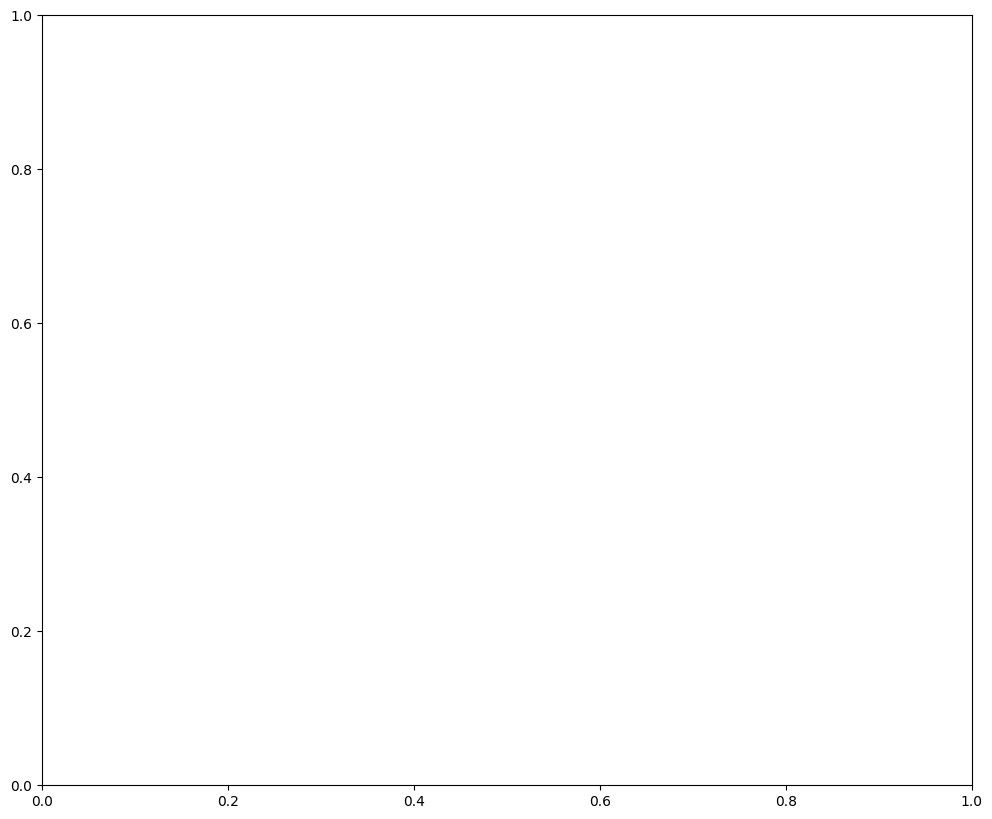

In [19]:
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
if predictions is not None:
    np.random.seed(42)
    random_colors = np.random.rand(62, 3)
    cmap = ListedColormap(random_colors)
    plt.figure(figsize=(12, 10))

    if y_test_int.ndim == 1:
        sample_labels = y_test_int
    else:
        sample_labels = np.argmax(y_test_int, axis=1)

    scatter = plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=sample_labels, cmap=cmap, s=3, alpha=0.5)
    colorbar = plt.colorbar(scatter)

    colorbar.set_ticks(np.arange(62))
    colorbar.set_ticklabels([label_transform(i) for i in range(62)])
    colorbar.ax.tick_params(labelsize=8)

    texts = []
    for i in range(62):
        mask = sample_labels == i
        mean_x = np.mean(images_tsne[mask, 0])
        mean_y = np.mean(images_tsne[mask, 1])
        label = label_transform(i)
        color = random_colors[i]
        text_color = 'white' if np.mean(color) < 0.5 else 'black'
        texts.append(plt.text(mean_x, mean_y, label, fontsize=9, ha='center', va='center',
                              bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'), color=text_color))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.7))

    plt.title('t-SNE visualization of EMNIST ByClass subset')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.savefig('tsne_visualization_ours.png', dpi=300)
    plt.show()
else:
    print("No t-SNE results to visualize.")

7/7 [==============================] - 1s 26ms/step


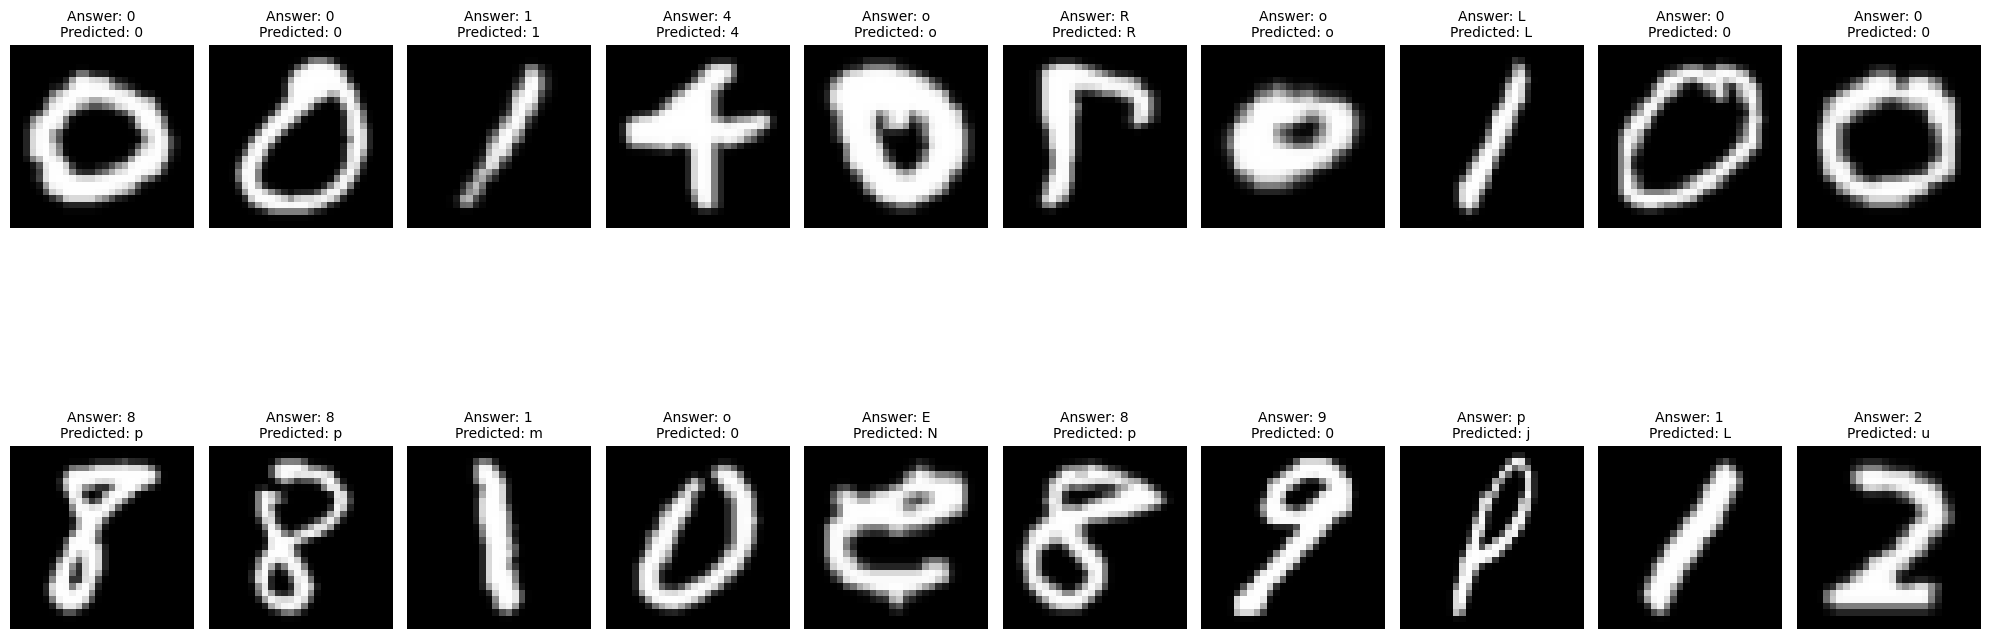

: 

In [10]:
num_samples = 200
sample_indices = np.random.choice(num_test_samples, num_samples, replace=False)
sample_images = x_test_corrected[sample_indices]
sample_labels = y_test_int[sample_indices]

predicted_labels = model.predict(sample_images)
predicted_labels_int = np.argmax(predicted_labels, axis=1)

correct_indices = np.where(predicted_labels_int == sample_labels)[0]
incorrect_indices = np.where(predicted_labels_int != sample_labels)[0]

correct_images = sample_images[correct_indices]
correct_labels = sample_labels[correct_indices]
correct_predictions = predicted_labels_int[correct_indices]

incorrect_images = sample_images[incorrect_indices]
incorrect_labels = sample_labels[incorrect_indices]
incorrect_predictions = predicted_labels_int[incorrect_indices]

num_display = 10
plt.figure(figsize=(20, 10))

for i in range(min(num_display, len(correct_images))):
    plt.subplot(2, num_display, i + 1)
    plt.imshow(correct_images[i].reshape(28, 28), cmap='gray')
    true_label = label_to_char(correct_labels[i])
    predicted_label = label_to_char(correct_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

for i in range(min(num_display, len(incorrect_images))):
    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(incorrect_images[i].reshape(28, 28), cmap='gray')
    true_label = label_to_char(incorrect_labels[i])
    predicted_label = label_to_char(incorrect_predictions[i])
    plt.title(f"Answer: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()